In [9]:
import numpy as np
from tqdm import tqdm
from IPython.display import display, clear_output
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [133]:
### Settings and parameters
length_x  = 400    # resolution x direction  # default 400
length_y  = 100    # resolution y direction
rho0      = 1      # average density
tau       = 0.6    # collision timescale (relaxation term)
# tau = 1.9739
# tau = 0.9
n_steps   = 4000   # number of timesteps
uMax      = 0.1    # maximum velocity of Poiseuille inflow
inlet_idx = 0
outlet_idx = length_x - 1
pipe_length = length_y - 2  # L
inlet_slice = np.s_[:, 0]
outlet_slice = np.s_[:, length_x - 1]

In [3]:
### Cylinder parameters
# X.shape: (100, 400) Y shape: (100, 400)
X, Y = np.meshgrid(range(length_x), range(length_y))
# INFO: shape the same as all space, but only partially filled with cylinder
# cylinder shape: (100, 400)
cylinder_radius = 4
cylinder = (X - length_x / 4) ** 2 + (Y - length_y / 2) ** 2 < (length_y // cylinder_radius) ** 2

In [100]:
### Lattice constants(speeds, weights)
number_latices = 9
# New style
idxs = np.arange(number_latices)
velocities_x = np.array([
    [-1, 0, 1,],
    [-1, 0, 1,],
    [-1, 0, 1,],
])
velocities_y = np.array([
     [1,  1,  1,],
     [0,  0,  0,],
    [-1, -1, -1,],
])
weights_mat = np.array([
    [1/36, 1/9, 1/36,],
    [1/9,  4/9, 1/9,],
    [1/36, 1/9, 1/36,],
])

# Old style
#                               0    1     2    3    4     5     6    7     8
#                               CE   N     NE   E    SE    S    SW    W     NW
latice_velocity_x = np.array([  0,   0,    1,   1,   1,    0,   -1,  -1,   -1,  ])
latice_velocity_y = np.array([  0,   1,    1,   0,  -1,   -1,   -1,   0,    1,  ])
weights = np.array([          4/9, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36,  ]) # sums to 1
# NOTE: this should be updated to the new style
lat_cent_col = np.s_[:, [0, 1, 5]]
lat_left_col = np.s_[:, [6, 7, 8]]
lat_right_col= np.s_[:, [2, 3, 4]]

# Helper call to convert old lattices to the new one
old_points = np.array("C N NE E SE S SW W NW".split())
new_points = np.array([
    ["NW", "N", "NE", ],
    ["W", "C", "E", ],
    ["SW", "S", "SE"]
]).reshape(-1)
old_to_new_indexes = [list(old_points).index(item) for item in new_points]
new_to_old_indexes = [list(new_points).index(item) for item in old_points]

assert (new_points == old_points[old_to_new_indexes]).all()
assert (old_points == new_points[new_to_old_indexes]).all()
assert (old_points == old_points[old_to_new_indexes][new_to_old_indexes]).all()


In [70]:
### Initial conditions
def init_random_cos():
    # F.shape: (100, 400, 9)
    F = np.ones((length_y, length_x, number_latices)) #* rho0 / number_latices
    np.random.seed(42)
    F += 0.01 * np.random.randn(length_y, length_x, number_latices)
    X, _ = np.meshgrid(range(length_x), range(length_y))
    # F[0, 0] - 0.99 .. 3.45
    F[:, :, 3] += 2 * (1 + 0.2 * np.cos(2 * np.pi * X / length_x * 4))  # 1.6..2.4
    rho = np.sum(F, 2)
    for i in idxs:
        F[:, :, i] *= rho0 / rho
    # F[0, 0] - 8 .. 29
    return F

def poiseuille_profile(y_phys):
    return 4 * uMax / (pipe_length ** 2) * (y_phys * pipe_length - y_phys * y_phys)

def init_poiseuille():
    rho = 1
    
    y, x = np.meshgrid(np.arange(length_y), np.arange(length_x))
    F_in = np.empty((length_x, length_y, number_latices))
    y_phys = y - 0.5;
    ux = poiseuille_profile(y_phys)
    uy = np.zeros((length_x, length_y))
    
    for idx in range(9):
        # 300, 100
        cu = 3 * (latice_velocity_x[idx] * ux + latice_velocity_y[idx] * uy);
        # 300, 100
        res = rho * weights[idx] * (1 + cu + 1/2 * cu ** 2 - 3/2*(ux**2 + uy **2));
        F_in[:, :, idx] = res
    F_in = np.rot90(F_in)
    return F_in


In [119]:
rho[outlet_slice].shape

(100,)

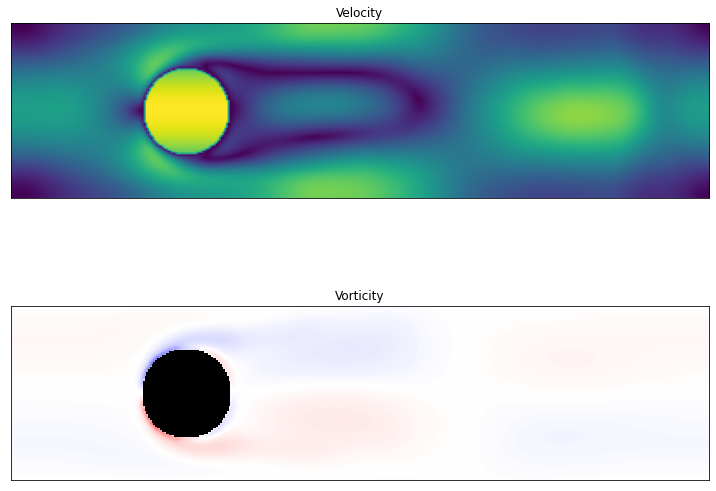

In [135]:
### Simulation(main loop)
cmap = plt.cm.bwr.copy()
cmap.set_bad('black')

plot = True
macroscopic = False
if plot:
    fig, axes = plt.subplots(2, figsize=(10, 8))
    for ax in axes:
        ax.invert_yaxis()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect('equal')
    fig.tight_layout()

# F = init_random_cos()
F = init_poiseuille()

def print_v(*data):
    if not plot:
        print(*data)

for it in range(n_steps):
# for it in range(10):

    # Set reflective boundaries
    bndryF = F[cylinder,:]   # shape: (3405, 9)
    # Action: to all cylinder coordinates assign such f_i values
    # FIXME: where do we get that array???
    # NOTE: should be fixed after boundary conditions implementation
    bndryF = bndryF[:,[0,5,6,7,8,1,2,3,4]]

    ### 1. Compute moments (for each latice)
    rho = np.sum(F, 2)  # shape: (100, 400)
    ux  = np.sum(F * latice_velocity_x, 2) / rho   # shape: (100, 400)
    uy  = np.sum(F * latice_velocity_y, 2) / rho   # shape: (100, 400)
    
    if macroscopic:
        ### 1.1 Compute macroscopic (dirichlet) boundary conditions
        ##  Inlet: Poiseuille profile
        y_phys = np.arange(length_y) - 0.5
        ux[inlet_slice] = poiseuille_profile(y_phys)
        uy[inlet_slice] = 0
        rho[inlet_slice] = 1 / (1 - ux[inlet_slice] * (
            F[inlet_slice][lat_cent_col].sum(axis=1) +
            2 * F[inlet_slice][lat_left_col].sum(axis=1))
        )
        ##  Outlet: Constant pressure
        print_v('-')
        print_v("rho outlet before", rho[outlet_slice].mean())
        rho[outlet_slice] = 1
        print_v("rho outlet after", rho[outlet_slice].mean())
        print_v("rho total", rho.mean())
        print_v("F[outlet_slice][lat_cent_col].sum(axis=1)", np.mean(F[outlet_slice][lat_cent_col].sum(axis=1)))
        print_v("2 * F[outlet_slice][lat_right_col].sum(axis=1)", np.mean(2 * F[outlet_slice][lat_right_col].sum(axis=1)))

        print_v("ux before", ux[outlet_slice].mean())
        ux[outlet_slice] = -1 + 1 / rho[outlet_slice] * (
            F[outlet_slice][lat_cent_col].sum(axis=1) +
            2 * F[outlet_slice][lat_right_col].sum(axis=1)
        )
        print_v("ux after", ux[outlet_slice].mean())
        uy[outlet_slice] = 0

    ### 2. Compute equilibrium
    OLD_RAILS = True
    if OLD_RAILS:
        F_eq = np.zeros(F.shape)
        for i, cx, cy, w in zip(idxs, latice_velocity_x, latice_velocity_y, weights):
            # (100, 400)
            F_eq[:,:,i] = rho * w * ( 1 + 3*(cx*ux+cy*uy)  + 9*(cx*ux+cy*uy)**2/2 - 3*(ux**2+uy**2)/2 )


    else:
        # https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html
        # https://discuss.pytorch.org/t/tf-extract-image-patches-in-pytorch/43837/4
        F_eq_l = np.zeros(F.shape)
        for x_idx in range(F.shape[0]):
            for y_idx in range(F.shape[1]):
                lattice = F[x_idx, y_idx, :]
                # reshape to the new convetion
                lattice = lattice[old_to_new_indexes].reshape(3, 3)
                rho_l = np.sum(lattice)
                ux_l = np.sum(lattice * velocities_x) / rho_l
                uy_l = np.sum(lattice * velocities_y) / rho_l
                F_eq_lattice = rho_l * weights_mat * (1 +
                    3 * (velocities_x * ux_l + velocities_y * uy_l) +
                    9 * (velocities_x * ux_l + velocities_y * uy_l) ** 2 / 2 - 
                    3 * (ux_l ** 2 + uy_l ** 2) / 2
                )
                # reshape back to the old convention
                F_eq_lattice = F_eq_lattice.reshape(-1)[new_to_old_indexes]
                F_eq_l[x_idx, y_idx, :] = F_eq_lattice
        F_eq = F_eq_l

    ### 3. Collide locally
    F = F - (F - F_eq) / tau

    # Apply boundary 
    # IDEA: copy that strange random array which was applied to a cylinder
    F[cylinder,:] = bndryF
    
    ### 4. Propagate to the neighbours
    for i, cx, cy in zip(idxs, latice_velocity_x, latice_velocity_y):
        F[:,:,i] = np.roll(F[:,:,i], (cx, cy), axis=(1, 0))
        

    if (it % 10 == 0 or it == n_steps - 1) and plot:
        ux[cylinder] = 0
        uy[cylinder] = 0
        # Note: Calculate vorticity as a difference 
        # Note: np.roll(ux, -1, axis=0) - shift all X velocity by one ROW down
        # vorticity.shape: (100, 400)
        vorticity = (
            (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - 
            (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1))
        )
        vorticity[cylinder] = np.nan
        
        # display velocity
        rho = np.sum(F, 2)
        ux  = np.sum(F * latice_velocity_x, 2) / rho
        uy  = np.sum(F * latice_velocity_y, 2) / rho
        u = np.sqrt(ux ** 2 + uy ** 2)
        axes[0].cla()
        axes[0].set_title("Velocity")
        axes[0].imshow(u)
        
        # Works but blink all the time
        axes[1].cla()
        axes[1].set_title("Vorticity")
        axes[1].imshow(vorticity, cmap=cmap)
        axes[1].get_images()[0].set_clim(-.1, .1)
        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)